In [21]:
# FASTA: Full Average Scaled Tiling Attention
# implement a sparse attention using triton using the following methods
# in the standard self attention, the attention weight is computed like this: attn_weight = query @ key.transpose(-2, -1) * scale_factor
# assume a function:
# def att_weight(Q,K_T):
#    return Q@K_T
# FASTA is a sparse approximation for the above function which works as follows:
# def att_weight(Q,K_T,n_chunks):
#    return Q@K_T # sparse approximation
# the Q and K are divided into equal sized chunks
# assume  QxK^T to be [Q0,Q1,....Qn-1]*[K0,K1,....Kn-1] where each of them are equal sized chunks from the initial embeddings.
# in the full product if Q0*K0 then you do the regular multiplication, but if Q0*K1 or whenever the indices are not same, do avg(Q0)*avg(K1) and then broadcast this value in the shape of that grid.
# create a triton kernel which implements the above operation if i==j then intra-index, if i!=j then inter-index
# generate code and test case for the kernels first before proceeding to the full implementation
# the overall time complexity should be O(n^2/c^2+n*d*c) where c is number of chunks

In [22]:
## standard torch self-attention
import torch

def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
        is_causal=False, scale=None, enable_gqa=False) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value

In [6]:
################################################################################

Using device: cuda
Warming up the GPU...
Starting benchmarking...


Benchmarking: 100%|█████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.72it/s]


Benchmarking completed!


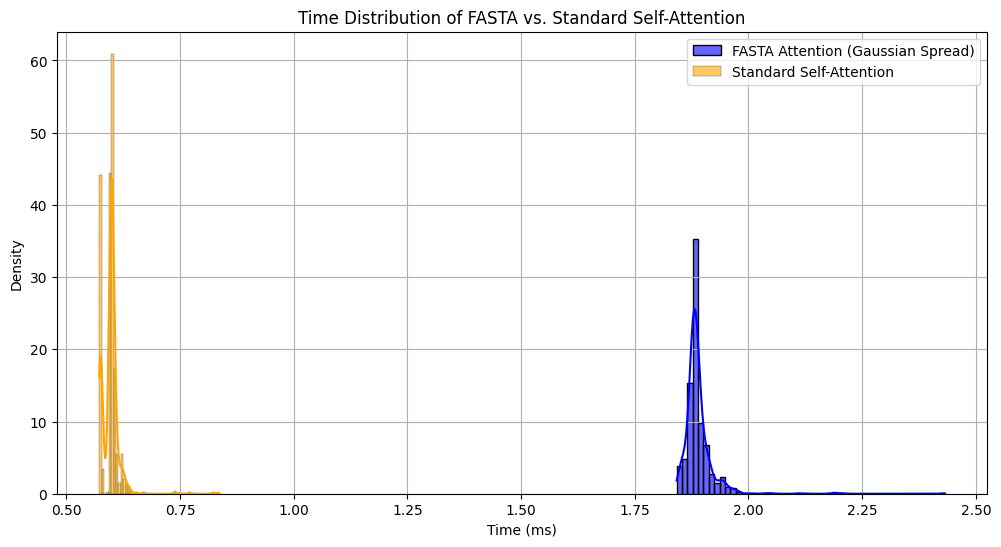

Summary Statistics:
FASTA Attention - Mean: 1.8892 ms, Std: 0.0341 ms
Standard Self-Attention - Mean: 0.5969 ms, Std: 0.0195 ms


In [124]:
import torch
import triton
import triton.language as tl
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress bar

@triton.jit
def sparse_attn_kernel_gaussian(
    Q_ptr, K_ptr, attn_ptr,
    N, D: tl.constexpr, BLOCK_SIZE: tl.constexpr,
    sigma: tl.constexpr,
    stride_q0, stride_q1,
    stride_k0, stride_k1,
    stride_attn0, stride_attn1,
):
    # Get the program ID and compute row and column block indices
    pid = tl.program_id(0)
    n_blocks = tl.cdiv(N, BLOCK_SIZE)
    row_block_idx = pid // n_blocks
    col_block_idx = pid % n_blocks
    
    # Calculate the starting positions of the current block
    row_start = row_block_idx * BLOCK_SIZE
    col_start = col_block_idx * BLOCK_SIZE
    
    # Create block offsets for Q and K
    offs_q = row_start + tl.arange(0, BLOCK_SIZE)
    offs_k = col_start + tl.arange(0, BLOCK_SIZE)
    offs_d = tl.arange(0, D)
    
    # Initialize the accumulator for attention weights
    acc = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)
    
    # Compute memory addresses for Q and K blocks
    q_ptrs = Q_ptr + offs_q[:, None] * stride_q0 + offs_d[None, :] * stride_q1
    k_ptrs = K_ptr + offs_k[:, None] * stride_k0 + offs_d[None, :] * stride_k1
    
    # Create masks to handle boundary conditions
    q_mask = offs_q[:, None] < N
    k_mask = offs_k[:, None] < N
    
    # Load Q and K blocks with masking
    q_block = tl.load(q_ptrs, mask=q_mask, other=0.0)
    k_block = tl.load(k_ptrs, mask=k_mask, other=0.0)
    
    # Intra-block attention: exact computation
    if row_block_idx == col_block_idx:
        for d in range(D):
            # Compute offsets for the d-th dimension
            q_offsets = (row_start + tl.arange(0, BLOCK_SIZE)) * stride_q0 + d * stride_q1
            k_offsets = (col_start + tl.arange(0, BLOCK_SIZE)) * stride_k0 + d * stride_k1
            
            # Load the d-th column of Q and K
            q_vals = tl.load(Q_ptr + q_offsets, mask=(tl.arange(0, BLOCK_SIZE) < N), other=0.0)
            k_vals = tl.load(K_ptr + k_offsets, mask=(tl.arange(0, BLOCK_SIZE) < N), other=0.0)
            
            # Update the accumulator with the outer product
            acc += q_vals[:, None] * k_vals[None, :]
    
    # Inter-block attention: Gaussian-like spread approximation
    if row_block_idx != col_block_idx:
        # Compute vector averages for Q and K
        avg_q_vector = tl.sum(q_block, axis=1) / D  # Shape: (BLOCK_SIZE,)
        avg_k_vector = tl.sum(k_block, axis=1) / D  # Shape: (BLOCK_SIZE,)
        
        # Compute the outer product of the averaged vectors
        outer = avg_q_vector[:, None] * avg_k_vector[None, :]  # Shape: (BLOCK_SIZE, BLOCK_SIZE)
        
        # Compute Gaussian weights based on relative positions within the block
        # Define the center of the block
        center = (BLOCK_SIZE - 1) / 2.0
        
        # Generate grid coordinates and cast to float32
        i = tl.cast(tl.arange(0, BLOCK_SIZE)[:, None], tl.float32)  # Shape: (BLOCK_SIZE, 1)
        j = tl.cast(tl.arange(0, BLOCK_SIZE)[None, :], tl.float32)  # Shape: (1, BLOCK_SIZE)
        
        # Calculate the squared distance from the center for each (i,j)
        distance_sq = (i - center) * (i - center) + (j - center) * (j - center)  # Shape: (BLOCK_SIZE, BLOCK_SIZE)
        
        # Compute Gaussian weights
        gaussian_weights = tl.exp(-distance_sq / (2.0 * sigma * sigma))  # Shape: (BLOCK_SIZE, BLOCK_SIZE)
        
        # Normalize Gaussian weights to ensure the sum equals 1
        gaussian_weights /= tl.sum(gaussian_weights)
        
        # Apply Gaussian weights to the outer product
        acc += outer * gaussian_weights
    
    # Calculate offsets for storing the attention weights
    offs_attn_i = row_start + tl.arange(0, BLOCK_SIZE)
    offs_attn_j = col_start + tl.arange(0, BLOCK_SIZE)
    
    # Compute memory addresses for storing the attention weights
    attn_ptrs = attn_ptr + offs_attn_i[:, None] * stride_attn0 + offs_attn_j[None, :] * stride_attn1
    
    # Create a mask to handle boundary conditions during storage
    mask = (offs_attn_i[:, None] < N) & (offs_attn_j[None, :] < N)
    
    # Store the computed attention weights with masking
    tl.store(attn_ptrs, acc, mask=mask)

def get_attn_weight_gaussian(Q, K, block_size=128, sigma=1.0):
    """
    Computes FASTA attention using Triton with Gaussian-like spread.
    
    Args:
        Q (torch.Tensor): Query tensor of shape (N, D)
        K (torch.Tensor): Key tensor of shape (N, D)
        block_size (int): Size of attention blocks
        sigma (float): Standard deviation for Gaussian spread
    
    Returns:
        torch.Tensor: Attention weights of shape (N, N)
    """
    N, D = Q.shape
    # Ensure tensors are contiguous
    Q = Q.contiguous()
    K = K.contiguous()
    
    # Create output tensor
    attn = torch.empty((N, N), device=Q.device, dtype=Q.dtype)
    
    # Calculate grid size
    n_blocks = triton.cdiv(N, block_size)
    grid = (n_blocks * n_blocks,)
    
    # Launch kernel
    sparse_attn_kernel_gaussian[grid](
        Q, K, attn,
        N, D, block_size, sigma,
        Q.stride(0), Q.stride(1),
        K.stride(0), K.stride(1),
        attn.stride(0), attn.stride(1),
    )
    
    return attn

def standard_self_attention(Q, K):
    """
    Computes standard self-attention using PyTorch's optimized matrix multiplication.
    
    Args:
        Q (torch.Tensor): Query tensor of shape (N, D)
        K (torch.Tensor): Key tensor of shape (N, D)
    
    Returns:
        torch.Tensor: Attention weights of shape (N, N)
    """
    return Q @ K.T

def visualize_attention_blocks(attn_fasta, attn_ref, block_size=8, block_i=0, block_j=1):
    """
    Visualizes specific attention blocks for comparison.
    
    Args:
        attn_fasta (torch.Tensor): FASTA attention weights.
        attn_ref (torch.Tensor): Reference (standard) attention weights.
        block_size (int): Size of the attention block to visualize.
        block_i (int): Block row index.
        block_j (int): Block column index.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    row_start = block_i * block_size
    col_start = block_j * block_size
    row_end = min(row_start + block_size, attn_fasta.shape[0])
    col_end = min(col_start + block_size, attn_fasta.shape[1])
    
    fasta_block = attn_fasta[row_start:row_end, col_start:col_end].cpu().numpy()
    ref_block = attn_ref[row_start:row_end, col_start:col_end].cpu().numpy()
    diff_block = fasta_block - ref_block
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.heatmap(ref_block, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Reference Attention Block")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(fasta_block, annot=True, fmt=".2f", cmap="viridis")
    plt.title("FASTA Attention Block (Gaussian Spread)")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(diff_block, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Difference Block")
    
    plt.show()

def test_fasta_attention_gaussian_benchmark():
    """
    Benchmark function for FASTA attention implementation using Gaussian-like spread
    and standard self-attention. Runs each attention computation 1000 times and
    plots the time distributions.
    """
    # Test parameters
    N = 1024*4  # Increased sequence length for better benchmarking
    D = 128   # Increased hidden dimension
    block_size = 32*4
    sigma = 1.5  # Standard deviation for Gaussian spread
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")
    
    # Generate random inputs
    torch.manual_seed(0)
    Q = torch.randn(N, D, device=device, dtype=torch.float32)
    K = torch.randn(N, D, device=device, dtype=torch.float32)
    
    # Warm-up runs to stabilize GPU performance
    print("Warming up the GPU...")
    for _ in range(10):
        attn_fasta = get_attn_weight_gaussian(Q, K, block_size=block_size, sigma=sigma)
        attn_ref = standard_self_attention(Q, K)
    torch.cuda.synchronize() if device == 'cuda' else None
    
    # Number of benchmarking iterations
    num_iterations = 1000
    
    # Initialize lists to store timing data
    fasta_times = []
    standard_times = []
    
    print("Starting benchmarking...")
    # Use tqdm for progress visualization
    for _ in tqdm(range(num_iterations), desc="Benchmarking"):
        # Benchmark FASTA attention
        if device == 'cuda':
            torch.cuda.synchronize()
            start_fasta = torch.cuda.Event(enable_timing=True)
            end_fasta = torch.cuda.Event(enable_timing=True)
    
            start_fasta.record()
            attn_fasta = get_attn_weight_gaussian(Q, K, block_size=block_size, sigma=sigma)
            end_fasta.record()
    
            torch.cuda.synchronize()
            elapsed_fasta = start_fasta.elapsed_time(end_fasta)  # Time in milliseconds
        else:
            import time
            start_fasta = time.time()
            attn_fasta = get_attn_weight_gaussian(Q, K, block_size=block_size, sigma=sigma)
            end_fasta = time.time()
            elapsed_fasta = (end_fasta - start_fasta) * 1000  # Convert to milliseconds
    
        fasta_times.append(elapsed_fasta)
    
        # Benchmark standard self-attention
        if device == 'cuda':
            torch.cuda.synchronize()
            start_std = torch.cuda.Event(enable_timing=True)
            end_std = torch.cuda.Event(enable_timing=True)
    
            start_std.record()
            attn_ref = standard_self_attention(Q, K)
            end_std.record()
    
            torch.cuda.synchronize()
            elapsed_std = start_std.elapsed_time(end_std)  # Time in milliseconds
        else:
            import time
            start_std = time.time()
            attn_ref = standard_self_attention(Q, K)
            end_std = time.time()
            elapsed_std = (end_std - start_std) * 1000  # Convert to milliseconds
    
        standard_times.append(elapsed_std)
    
    print("Benchmarking completed!")
    
    # Convert timing lists to NumPy arrays for easier handling
    fasta_times = torch.tensor(fasta_times).cpu().numpy()
    standard_times = torch.tensor(standard_times).cpu().numpy()
    
    # Plotting the time distributions
    plt.figure(figsize=(12, 6))
    
    sns.histplot(fasta_times, color='blue', label='FASTA Attention (Gaussian Spread)', kde=True, stat="density", bins=50, alpha=0.6)
    sns.histplot(standard_times, color='orange', label='Standard Self-Attention', kde=True, stat="density", bins=50, alpha=0.6)
    
    plt.title('Time Distribution of FASTA vs. Standard Self-Attention')
    plt.xlabel('Time (ms)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Optional: Print summary statistics
    print("Summary Statistics:")
    print(f"FASTA Attention - Mean: {fasta_times.mean():.4f} ms, Std: {fasta_times.std():.4f} ms")
    print(f"Standard Self-Attention - Mean: {standard_times.mean():.4f} ms, Std: {standard_times.std():.4f} ms")
    
    # Optional: Visualize a specific attention block
    # visualize_attention_blocks(attn_fasta, attn_ref, block_size=32, block_i=0, block_j=1)

if __name__ == "__main__":
    test_fasta_attention_gaussian_benchmark()
